# An iterative method for correcting and smoothing vehicle trajectories based on first principles

# Introduction
In this paper, we propose an iterative method for correcting and smoothing longitudinal vehicle trajectory data. One iteration comprises four types of calculations: differentiation, correction, smoothing, and integration. 
In differentiation, we compute speeds, accelerations, and jerks from positions; in correction, we eliminate outliers in speeds, especially negative values; in smoothing, we reduce noises in accelerations and jerks; and in integration, we recalculate accelerations, speeds, and positions from jerks. We choose the adaptive average method for correction and the Gaussian filter for smoothing. 
We incorporate three first principles into the four calculations and the termination condition: (P1) internal consistency among variables at different orders, satisfying both differentiation and integration relations; (P2) bounded speeds, accelerations, and jerks; (P3) minimizing the mean absolute errors (MAEs) between the reconstructed and raw positions. P1 is used in differentiation and integration; P2 is used in correction and smoothing and serves as the criterion to determine when the iterations terminate; P3 is used in integration. 

In [11]:
# import packages we may use in this script
import pandas as pd
import io
import numpy as np
import scipy
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from matplotlib import cm
 
#include different correction methods, filters and optimization functions
np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x : '%.3f' % x)
np.set_printoptions(precision=3, suppress=True)#3 digit, no scientific notation
np.set_printoptions(threshold=np.inf) #no ellipses

# Longitudinal vehicle trajectories correction and smoothing
To better illustrate the calculations in the proposed method, we plot Figure 3. One loop in the dashed black box represents one iteration. One iteration includes four different colored arrows that represent four types of calculations in the method: the red arrow represents differentiation, the green arrow represents correction, the yellow arrow represents smoothing, and the blue arrow represents integration. The entire framework contains four layers. All the physical quantities in one layer should be internally consistent, satisfying both differentiation and integration relations, and once a correction or smoothing procedure is completed, we proceed to the next layer. A detailed description of each calculation will follow.

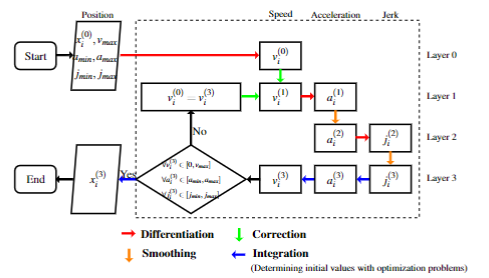

Figure 2: The framework of the calculations



The notation list is as below:<br>
Table 1: List of notations

|parameter | remark | parameter | remark |
| :----:| :----: | :----: | :----: |
| $t$ | Time | $T$ | Total recording duration of one vehicle |
| $\Delta t$ | Time step size | $i$ | $=t/\Delta t$, number of the time step |
| $x^{(l)}_i$ | Position at $l$ th layer at time step $i$ | $v^{(l)}_i$ | Speed at $l$ th layer at time step $i$ |
| $a^{(l)}_i$  | Acceleration at $l$ th layer at time step $i$  | $j^{(l)}_i$ | Jerk at $l$ th layer at time step $i$ |
| $v_{max}$ | Upper bound of speeds | $a_{min}$ | Lower bound of accelerations |
| $a_{max}$ | Upper bound of accelerations | $j_{min}$ | Lower bound of jerks |
| $j_{max}$ | Upper bound of jerks | $\phi_i$ | Gaussian kernel |
| $\psi_i$ | Gaussian kernel after truncation | $E(\cdot)$ | Expected value (mean value) |
| $\sigma(a)$ | Standard derivation of the Gaussian filter for smoothing the acceleration | $\sigma(j)$ | Standard derivation of the Gaussian filter for smoothing the jerk |


Table 2: List of each term in the code

|parameter | remark | parameter | remark |
| :----:| :----: | :----: | :----: |
| up_wj  | Upper bound of $\sigma^{(j)}$ | low_wj | Lower bound of $\sigma^{(j)}$ |
| up_wa | Upper bound of $\sigma^{(a)}$ | low_wa | Lower bound of $\sigma^{(a)}$  |
| sigma | Standard derivation | delta_t | Time step |
| up_v | Upper bound of speed | down_v | Lower bound of speed |
| up_a | Upper bound of acceleration | down_a | Lower bound of acceleration |
| up_j | Upper bound of jerk | down_j | Lower bound of jerk |
| lower_order | The physical quantity to be differentiated | higher_order | The higher-order physical quantity to be calculated |
| opt_id | Indicator of the optimization objective (Here it is 1, represeting $l_1$ norm)  |
|order_ind | Indicator of variables at different orders (1: speed, 2: acceleration, 3:jerk) |
|filter_id | Indicator of the filter (Here it is 1, represent the Gaussian filter) | 

## Four calculations

### Differentiation
Because the speed and acceleration presented in the original NGSIM dataset are erroneous. The input of our framework is the raw trajectory, and we calculate the raw speed according to the raw velocity. We adopt the symplectic discretization (mixed implicit-explicit Euler discretization) method, which was analytically proved to be the only physically meaningful discretization method that can always lead to collision-free and forward-traveling solutions. We calculate speeds using implicit discretization, accelerations using explicit discretization, and jerks using implicit discretization. The general discretized longitudinal vehicle motion dynamic can be illustrated as follows:

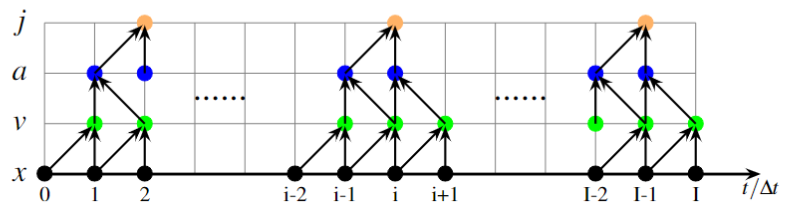

Figure 3: Illustration of discretized longitudinal vehicle dynamic


The speed, acceleration, and jerk at each time instant can be calculated as follows:
$$
v^{(l)}_i = \frac{x^{(l)}_i-x^{(l)}_{i-1}}{\Delta t}, \ \ i=1,2,3,......,I, (1a)
$$
$$
a^{(l)}_i = \frac{v^{(l)}_{i+1}-v^{(l)}_{i}}{\Delta t}=\frac{x^{(l)}_{i+1}-2x^{(l)}_{i}+x^{(l)}_{i-1}}{(\Delta t)^2},  \ \ i=1,2,3,......,I-1 (1b)
$$
$$
j^{(l)}_i = \frac{a^{(l)}_{i}-a^{(l)}_{i-1}}{\Delta t}=\frac{x^{(l)}_{i+1} - 3x^{(l)}_{i} + 3x^{(l)}_{i-1} - x^{(l)}_{i-2}}{(\Delta t)^3}, \ \ i=2,3,4,......,I-1 (1c)
$$
Once the four physical quantities are at the same layer, they should satisfy (1a) to (1c). There are $I$ discrete position values in the position profile. The lengths of corresponding speed, acceleration and jerk profiles are $I-1$, $I-2$ and $I-3$, respectively. The speed profile covers $1$ to $I$. The acceleration covers $1$ to $I-1$, while the jerk profile starts at $2$ and ends at $I-1$. All higher-order derivatives at any time instant can be obtained from lower-order derivatives. 

In [12]:
def differentiation(lower_order, higher_order, delta_t,  order_ind):
    import copy
    if order_ind == 2: #differentiate explicit (for acceleration)
        new_array = copy.deepcopy(lower_order);
        update_higher = copy.deepcopy(higher_order);
        update_higher[ : len(new_array)-1] = (new_array[1 : ]-new_array[ : len(new_array)-1]) / delta_t
    elif order_ind == 1 or order_ind == 3: #differentiate implicit (for speed and jerk)
        new_array = copy.deepcopy(lower_order);
        update_higher = copy.deepcopy(higher_order);
        update_higher[ 1 : ] = (new_array[ 1 : ]-new_array[ : len(new_array)-1]) / delta_t
        
    return update_higher

The implicit discretization can be written as follows, it can be used to calculate speeds and jerks.

### Speed correction
The objective of this step is to remove outliers in the speed profile which are generated because of errors in position detection. Let $x^{(0)}_i$ and $v^{(0)}_i$ denote the raw position and the speed calculated from the raw position at time $i$. <br>
We use the adaptive average method to correct the speed profile, in which we average velocities starting at the time when the outlier occurs until such average velocity is within the range. The raw speed values are then replaced by the average speed. <br>
For example, in the figures below, $v^{(0)}_{i+1}$ is negative and needs correction. We add up the speeds starting from $v^{(0)}_{i+1}$ and found that the nearest time point that can lead to a physically feasible average speed is $i+3$. Therefore, we replace the raw speeds in such period with the average speed between $i$ and $i+3$, as illustrated by the red line, and the new positions are shown as the red nodes. Similarly, when a speed exceeds the upper bound, we also replace the raw speeds in such period with the average speed. In both examples, the average speed can be calculated via (2).<br>

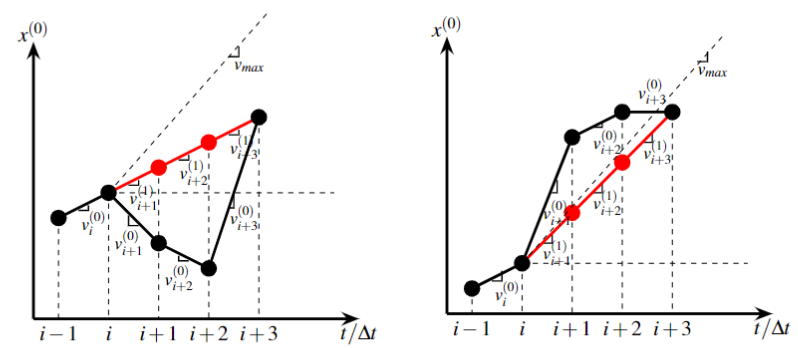

Figure 4: Illustration of the adaptive average method

$$
v^{(1)}_{i+1}= v^{(1)}_{i+2}=  v^{(1)}_{i+3} = \frac{v^{(0)}_{i+1}+v^{(0)}_{i+2}+v^{(0)}_{i+3}}{3}. (2)
$$

In [13]:
def remove_outlier(data, time, up_v, down_v, order_ind): #raw speed, time instant, the upper boundary and the lower boundary
    import copy
    import matplotlib.pyplot as plt  
    from scipy.interpolate import CubicSpline
    from scipy.interpolate import interp1d
    new_array = copy.deepcopy(data);
    for i in range(len(new_array)): 
        if new_array[i] < down_v or new_array[i] > up_v: # the data that is out of the range
            if i <= len(new_array) - 1:        
                for t in range(1,len(new_array)-i): #the points after that points
                    if sum(new_array[i:i+t]/t) >= down_v and sum(new_array[i:i+t])/t <= up_v: #the average value in this duration is within range
                        dot_num = t #how many dots in this segment
                        y = [sum(new_array[i:i+t])/t, sum(new_array[i:i+t])/t]; x = [time[i],time[i+t]]
                        sp_curve = interp1d(x, y) #relation between x and y, average speed that replace the original one
                        x_revised = sp_curve(time[i:i+t]) #Eq 2
                        new_array[i:i+t] = x_revised[:]
                        break
            #If the last several points have negative speed values, replace negative values with 0 
            if i >= 0.9 * (len(new_array) - 1):          
                if sum(new_array[i:]) < down_v or sum(new_array[i:])>= (len(new_array)-i)*up_v:
                    y = [new_array[i-1], new_array[i-1]]; x = [time[i],time[-1]]
                    sp_curve = interp1d(x, y)
                    x_revised = sp_curve(time[i:])
                    new_array[i:] = x_revised[:]

    return new_array

### Acceleration and jerk smoothing
Here we consider the Gaussian filter, which convolves the input signal with a kernel having the shape of a Gaussian distribution. The Gaussian kernel for smoothing point $i$ can be written as (3): <br>
$$
\phi_i = \frac{1}{\sqrt{2\pi\sigma ^2}}e^{-\frac{(i-i^*)^2}{2\sigma^2}},(3)
$$
where $i^*$ represents the time instant of the target value we want to smooth, $\sigma$ is the standard deviation. However, a true Gaussian response would have infinite impulse responses and it decays rapidly. Therefore, we truncated the Gaussian distribution at some standard derivations, and the truncated Gaussian kernel can be written as: <br>
$$
\psi_i = \frac{\phi_i}{\sum_{\delta=i^*-p\sigma}^{\delta = i^*+p\sigma}\phi_{\delta}},  (4)
$$
where $p$ represents that we smooth the value at $i^*$ with values from $i^*-p\sigma$ to $i^*+p\sigma$.  We choose $p=4$ where the amplitude of the Gaussian function is about $3\times 10^{-4}$ of that at $i^*$, and handle the edge of the signal via zero padding.

In [14]:
def smooth(data, sigma, T_x, filter_id, order_ind): # input is the data to be smoothed, one dimentional vector
    import copy, math
    import matplotlib.pyplot as plt  
    from scipy.ndimage import gaussian_filter1d, uniform_filter1d
    delta_t = 0.1 #sec, sampling frequency is 10hz
    array = copy.deepcopy(data);
    if filter_id == 1: #Gaussian filter
        if order_ind == 1:
            new_data = gaussian_filter1d(array, sigma, mode = 'nearest').reshape(len(array),1) #Eq 4 wrap
        else:
            if sigma == 0:
                new_data = array.reshape(len(array),1)
            else:
                new_data = gaussian_filter1d(array, sigma, mode = 'constant').reshape(len(array),1) #Eq 4 wrap
    elif filter_id == 2: #Exponential moving average filter
        window_width = 3*T_x
        array = array.reshape(len(array),1)
        new_data = np.zeros((2*int(3*T_x) + len(array) , 1)); print(np.shape(new_data), np.shape(new_data[int(3*T_x+1) : int(3*T_x+1+len(array))]), "t",int(3*T_x+1+len(array)), len(array))
        new_data[int(3*T_x+1) : int(3*T_x+1+len(array))] = array
        for i in range(int(3*T_x)+1 , int(3*T_x)+len(array)+2):
            Z = 0; X_item = 0
            for k in range(i-int(window_width),i+int(window_width)):#one kernel of smoothing
                Z = Z + math.exp(-abs(i-k)/(T_x))
                X_item = X_item + new_data[k-1]*math.exp(-abs(i-k)/(T_x)) #one time-step has one X_item
            new_data[i-1] = X_item / Z #reconstructed data at i 
        new_data = new_data[int(window_width+1) : int(window_width+1+len(array))]     

    return new_data

### Integration
According to the 'internal consistency' mentioned in P1, accelerations should be equal to integrals of jerks, speeds should be equal to integrals of accelerations, and positions should be equal to integrals of speeds. Accelerations, speeds, and positions can be calculated as follows: 
$$
a^{(l)}_i = a^{(l)}_1+\sum_{\delta=2}^{\delta=i} j^{(l)}_{\delta} \Delta t,\ \ i = 2,3,4, ......,I-1, (6a)
$$
$$
v^{(l)}_i = v^{(l)}_1+\sum_{\delta=1}^{\delta=i} a^{(l)}_{\delta} \Delta t,\ \ i = 1,3,4, ......,I-1, (6b)
$$
$$
x^{(l)}_i = x^{(l)}_1+\sum_{\delta=0}^{\delta=i} v^{(l)}_{\delta} \Delta t, \ \ i = 1,3,4,......,I, (6c)
$$
where $l$ represents the layer in Figure 2, here $l=3$, $I = T/\Delta t$, $T$ denotes the recording duration, $\Delta t$ is the time step size. $a^{(l)}_1$, $v^{(l)}_1$, $x^{(l)}_0$ are the initial states of the acceleration, speed, and position profiles, respectively. 
The calculation is illustrated in Figure 5, with each black node representing
a position, each green node representing a speed, each blue node representing an acceleration, and each yellow node representing a jerk. The arrows' directions indicate the directions of calculations. The calculation can be regarded as an inversed procedure of the differentiation. However, unlike in
differentiation where the entire speed, acceleration, and jerk profiles can be calculated once the position profile is known, the initial values of the acceleration, speed, and position profiles are still unknown when calculating them by integrating the jerk profile, as shown by the hollow nodes.

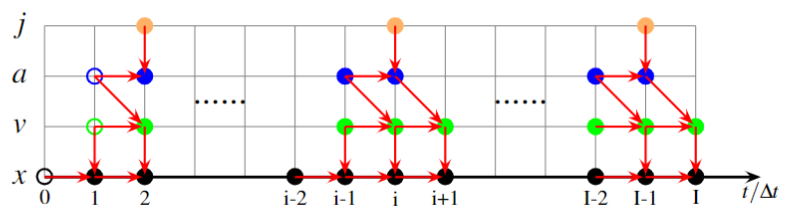

Figure 5: Illustration of initial values in the integration

As pointed out by P3, we should minimize the MAE between the smoothed and the raw positions to preserve the main information in the raw data.
 Correspondingly, the MAEs between the acceleration and speed profiles before and after integration should also be modest. To obtain the best initial acceleration, we formulate an optimization problem to minimize the MAE between the integral of the jerk profile and the acceleration profile at layer 2 ($a^{(2)}$) with the objective function as follows: 

$$
E(|a^{(3)} - a^{(2)}|) = \frac{1}{I-1}\sum_{i=1}^{I-1} |a^{(3)}_i - a^{(2)}_i| = \frac{1}{I-1}\sum_{i=1}^{I-1}| a^{(3)}_1+ \Delta t \sum_{\delta=2}^{i} j^{(3)}_{\delta} - a^{(2)}_i|,
$$
where $a^{(2)}$ and $j^{(3)}$ are the outputs of 'acceleration and jerk smoothing'. Thus, the only unknown variable is $ a^{(3)}_1$. We choose the Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm \citep{fletcher2013practical} for solving the optimization problem, and $a^{(2)}_1$ as the initial guess of $a^{(3)}_1$.


In [15]:
#order indicator: 1: velocity implicit 2: acceleration explicit 3: jerk implicit
def function_opt(raw_data, cum_high_order, initial_value, delta_t, indicator, opt_ind, order_ind):
    import copy; data_r = copy.deepcopy(raw_data); 
    r_sqr1 = 0;
    r_sqr1 = np.sum( np.absolute(data_r - initial_value - cum_high_order * delta_t)) / len(cum_high_order) #Minimize MAE Eq 7
    if opt_ind == 1: #L1 opt
        return r_sqr1 

With $a^{(3)}_1$, as well as the entire jerk profile ($j^{(3)}$), we can calculate the entire acceleration profile $a^{(3)}$.
After obtaining the entire acceleration profile, the same procedure can be applied to calculate the speed profile. Similarly, the objective is to find out $v^{(3)}_1$ which leads to the minimum MAE between the integral of $a^{(3)}$ and $v^{(1)}$.<br>


In [16]:
def integrate(higher_order, original_lower, delta_t, indicator, opt_ind, order_ind): #if higher_order is smoothed jerk, then original_lower is differentiated acceleration 
    import copy; import matplotlib.pyplot as plt  
    from scipy.signal import butter,filtfilt,sosfilt; from scipy.ndimage import gaussian_filter1d
    from scipy.optimize import minimize, basinhopping, least_squares, fsolve
    new_lower = copy.deepcopy(original_lower); x0 = np.array((original_lower[0])) #the initial input of the optimization function
    
    #find initial state of lower-order variables
    input_cum = copy.deepcopy(higher_order) #cum higher order, eg: vel[0] + cum(acc[0:t-1]) = vel[t]
    if order_ind == 1 or order_ind == 3: #integrate objective (higher-order) is velocity or jerk
        for i in range(len(higher_order)):
            input_cum[i] = sum(higher_order[:i+1]);
    elif order_ind == 2: #integrate objective (higher-order) is acceleration
        input_cum[0] = 0
        for i in range(1,len(higher_order)):
            input_cum[i] = sum(higher_order[:i]);
    fun = lambda initial_state: function_opt(original_lower, input_cum, initial_state, delta_t, indicator, opt_ind, order_ind); #initial_state, objective variable
    res_a = minimize(fun, x0, method='BFGS'); lower_order_initial = res_a.x; #the final intial value we want to obtain, Eq 8
    
    new_lower[0] = lower_order_initial #change the initial state of the lower order variable profile
    for i in range(1,len(higher_order)): #upddate the integrated lower-order variables
        if order_ind == 1 or order_ind == 3: # acceleration or position
            new_lower[i] = new_lower[i-1] + delta_t * higher_order[i]
        else:  # speed
            new_lower[i] = new_lower[i-1] + delta_t * higher_order[i-1]
    
    return new_lower

After obtaining the entire acceleration profile, the same procedure can be applied to the speed profile. Similarly, the objective is to find out $v^{(3)}_1$ which leads to the minimum $MAE_{(v)}$ between the integral of $a^{(3)}$ and $v^{(1)}$.

## Iterative process
In each iteration, after we integrate the smoothed jerks to the accelerations and speeds according to (6a) and (6b),  we check whether all speeds, accelerations, and jerks are physically feasible. If there are still outliers, as Figure 2 shows, , we take the current speed profile as the new $v^{(0)}$ and conduct another iteration for tuning the results. 

Only when all speeds, accelerations, and jerks are physically feasible, we consider that we have completed all the calculations in the dashed black box in Figure 2, and the reconstructed data can satisfy the termination condition. We then calculate the ultimate output of our method. We integrate the speed profile back to the position profile according to (6c), and calculate the initial position that leads to the smallest $E(|x^{(3)} - x^{(0)}|)$. So far, the reconstructed vehicle trajectory is obtained. Therefore, with the choice of the Gaussian filter for smoothing the accelerations and jerks, the final flow chart of our method can be plotted as follows:

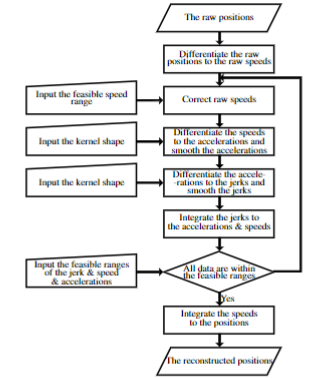

Figure 6: The final flow chart of the proposed method

In [40]:
def iteration1(data, sigma_a, sigma_j, T_a, T_j, delta_t, up_v, down_v, up_a, down_a, up_j, down_j, opt, filters): # the input is a matrix including the information of all variables
    import copy; import matplotlib.pyplot as plt  
    from scipy.signal import butter,filtfilt,sosfilt; from scipy.ndimage import gaussian_filter1d
    from scipy.optimize import minimize, basinhopping, least_squares, fsolve
    array = copy.deepcopy(data); update_array = copy.deepcopy(data); cal_array = np.zeros((1,22)); cal_array1 = np.zeros((1,22)) #to instore the raw data
    '''
    In one iteration, we go through the calculations mentioned before.
    '''
    ite_num = 1
    update_array[1:,-7] = remove_outlier(array[:,-7], array[:,2], up_v, down_v, 1)[1:] #Step 1: adaptive average method, remove outlier of speed
    update_array[1:-1,-6] = differentiation(update_array[:,-7], array[:,-6], delta_t, 2)[1:-1]; array[1:-1,-6] = copy.deepcopy(update_array[1:-1,-6]) #differentiated acceleration
        
    if (np.round(update_array[1:-1,-6],3) >= up_a).any() or (np.round(update_array[1:-1,-6],3) <= down_a).any(): #if there are out-range acceleration: step 2: smooth acceleration
        update_array[1:-1,-6] = smooth(update_array[1:-1,-6], sigma_a, T_a, filters, 2)[:,0] #smoothed acceleration
    else:
        update_array[1:-1,-6] = update_array[1:-1,-6]
    update_array[2:-1,-5] = differentiation(update_array[:,-6], array[:,-5], delta_t, 3)[2:-1] #differentiate to jerk
    if (abs(np.round(update_array[2:-1,-5],3)) >= up_j).any(): #if there are out-range jerk values: smooth jerk
        update_array[2:-1,-1] = smooth(update_array[2:-1,-5], sigma_j, T_j, filters, 3)[:,0] #smoothed jerk
    else:
        update_array[2:-1,-1] = update_array[2:-1,-5]
    update_array[1:-1,-2] = integrate(update_array[1:-1,-1], update_array[1:-1,-6], delta_t, 1, opt, 3) #integrated acceleration, step 3: adjust the initial state
    update_array[1:,-3] = integrate(update_array[1:,-2], update_array[1:,-7], delta_t, 2, opt, 2) #integrated speed
    '''If after one interation, there are still outliers, we need to repeat the process before.''' 
    for i in range(5000):
        new_ite = 0;
        if (np.round(update_array[1:,-3],3) < down_v).any() or (np.round(update_array[1:,-3],3) > up_v).any(): #if there is any negative speed   
            new_ite = 1; 
            update_array[1:,-3] = remove_outlier(update_array[:,-3], array[:,2], up_v, down_v, 1)[1:] #speed
            update_array[1:-1,-2] = differentiation(update_array[:,-3], array[:,-6], delta_t, 2)[1:-1] #acceleration
            update_array[2:-1,-1] = differentiation(update_array[:,-2], array[:,-5], delta_t, 3)[2:-1] #jerk
        if (np.round(update_array[2:-1,-2],3) >= up_a).any() or (np.round(update_array[2:-1,-2],3) <= down_a).any(): #if there are still out-range acceleration
            new_ite = 1; 
            update_array[1:-1,-2] = smooth(update_array[1:-1,-2], 1, 0.1, filters, 2)[:,0] #acceleration
            update_array[1:,-3] = integrate(update_array[1:,-2], update_array[1:,-7], delta_t, 2, opt, 2) #speed
            update_array[2:-1,-1] = differentiation(update_array[:,-2], array[:,-5], delta_t, 3)[2:-1] #jerk               
        if (abs(np.round(update_array[2:-1,-1],3)) >= up_j).any(): #if there are still out-range jerk
            new_ite = 1; 
            update_array[2:-1,-1] = smooth(update_array[2:-1,-1], 1, 0.1, filters, 3)[:,0] #jerk
            update_array[1:-1,-2] = integrate(update_array[1:-1,-1], update_array[1:-1,-6], delta_t, 1, opt, 3) #acceleration
            update_array[1:,-3] = integrate(update_array[1:,-2], update_array[1:,-7], delta_t, 2, opt, 2) #speed               
        if (abs(np.round(update_array[2:-1,-1],3)) <= up_j).all() and (np.round(update_array[1:,-3],3) >= down_v).all() and (abs(np.round(update_array[1:,-3],3)) < up_v).all() and (np.round(update_array[1:-1,-2],3) <= up_a).all() and (np.round(update_array[1:-1,-2],3) >= down_a).all():
            ite_num = 1+i if new_ite == 0 else 1+i+1; # the number of iterations
            break
        #print("id",update_array[0,0],"i",i,"-----------------------------------------------------------------------------")
    update_array[:,-4] = integrate(update_array[:,-3], array[:,-8], delta_t, 3, opt, 1) #integrated position
    position_error_vec = update_array[:,-4] - update_array[:,-8]; position_error = sum([abs(x) if x <= 0 else x for x in position_error_vec])/len(position_error_vec); #print("pos err", position_error) 
    #print("ite",ite_num, "id", data[0,0], "filter_id", filters, "sigma", sigma_a, sigma_j, "pos_error", position_error)
    return update_array, array, position_error, ite_num

# Choice of smoothing method and parameters
## Choice of the smoothing method
We analytically showed in the paper that the adaptive average method does not work for smoothing accelerations and jerks. Therefore, we omit the corresponding code here.



## Choice of parameters for smoothing
The parameters that need careful tuning are the standard derivations in the Gaussian filter for smoothing accelerations and jerks ($\sigma(a)$ and $\sigma(j)$). If we choose too small $\sigma(a)$ and $\sigma(j)$, the method will go through a large number of iterations, which significantly increases the computation cost and may also result in an increase in position errors following numerous integral calculations; on the other hand, if we choose too large standard derivations, the method can be completed in a single iteration, but the local information in the raw data may be overlooked. Except for the first iteration, the subsequent iterations are mainly used to fine-tune the values if the speed, acceleration, or jerk profiles still contain outliers after the first iteration. Therefore, we set both $\sigma(a)$ and $\sigma(j)$ to be 1 time-step in the subsequent iterations, and we will further discuss the parameter settings in the first iteration.

As pointed out by P3, the MAE in the raw positions should be kept to a minimum. To determine the best combination of $\sigma(a)$ and $\sigma(j)$, we choose the MAE between the raw and the reconstructed positions as the evaluation metric, and it can be calculated as follows:  
$$
E(|x^{(3)}-x^{(0)}|; \sigma(a),\sigma(j)) = \frac{\sum_{i=0}^{I}|x^{(3)}_i-x^{(0)}_i|}{I}, (8)
$$
where $I=T/\Delta t$ and $T$ is the recording duration. Based on this, we develop an algorithm to determine $\sigma(a)$ and $\sigma(j)$. The flow chart of the algorithm is shown as \reff{parameter_setting_flow}, and detailed processes will follow. <br>

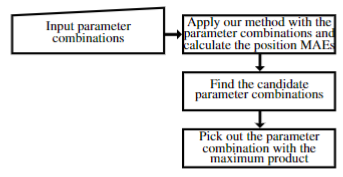


Figure 8: Process for determining standard derivations in the Gaussian filter

1. Investigate values ranging from 1 to 10 time-steps at 1 time-step interval for $\sigma(a)$ and $\sigma(j)$ (100 combinations), apply our method, and calculate the corresponding MAEs between the raw and the reconstructed positions. This step returns 100 MAEs.
2. Pick out all the combinations  which can satisfy $\varphi (x; \sigma(a), \sigma(j)) < 10^{-3}m$ as candidate parameter combinations, where $\varphi (x; \sigma(a), \sigma(j)) = \vert E(|x^{(3)}-x^{(0)}|; \sigma(a), \sigma(j))-\min E(|x^{(3)}-x^{(0)}|)\vert$ and $\min E(|x^{(3)}-x^{(0)}|)$ is the minimum MAE among the 100 values. 
3. Among the candidate parameter combinations, choose the one with the largest $\sigma(a) \cdot \sigma(j)$. If two combinations lead to the same $\sigma(a) \cdot \sigma(j)$, choose the one with the larger $\sigma(a)$. 

In [41]:
def dectect_window(data, sample_id, up_wj, low_wj, up_wa, low_wa, delta_t, up_v, down_v, up_a, down_a, up_j, down_j, 
                   T_a, T_j, opt_id, filters):
    import copy;
    input_data = copy.deepcopy(data) #raw matrix of one vehicle
    error_cum = np.zeros((up_wj-low_wj,up_wa-low_wa)) #to store the cummulative error under different window sizes
    id_set = sample_id #pick out all the ids, and create a list to store them
    for i in range(low_wj, up_wj): #smoothing window for jerk
        for k in range(low_wa, up_wa): #smoothing window for acceleration
            for n_id in range(len(id_set)): #go over each vehicle
                sub_veh = input_data[np.where(input_data[:,0] == id_set[n_id] )] #extract vehicle matrix according to vehicle id
                modify_traj, raw_traj, pos_err, ite = iteration1(sub_veh, k, i, T_a, T_j, delta_t, up_v, down_v, up_a, down_a, up_j, down_j, opt_id, filters) #trajectories after several iterations
                position_error = modify_traj[:,-4] - modify_traj[:,-8] # difference between modified trajectory and raw position
                position_error = [abs(x) if x <= 0 else x for x in position_error] 
                error_cum[i-low_wj,k-low_wa] += sum(position_error)/len(position_error) 
                #print("i=",i,"k=",k,"n_id",id_set[n_id], "error=",error_cum[i-low_wj,k-low_wa])
    error_ave = np.round(error_cum / len(id_set), 3) #Eq (8)
    '''step 2 in grid search algorithm, pick out all cadidate combinations, '0.00100000001' is 0.001m + acceptable error from the computer '''
    candidate_com = np.array(np.where(abs(np.round(error_ave,3) - round(np.min(error_ave),3)) <= 0.00100000001)) 
    '''Step 3, pick the one with the largest product'''
    index = np.argmax((candidate_com[0,:]+low_wj)*(candidate_com[1,:]+low_wa)) # step 3 in the closed-loop method, candidate_com[0,index]+low_wj is sigma_j and candidate_com[1,index]+low_wa is sigma_a
    sigma_pair = [candidate_com[1,index]+low_wa, candidate_com[0,index]+low_wj]
    print("id", data[0,0], "error_cum",error_ave, "candidate combination", candidate_com, "sigma pair:", sigma_pair, "pos_Err", round(np.min(error_ave),3))
    return error_ave, sigma_pair

# Method application with the NGSIM data

We first upload the dataset and change the unit


In [33]:
#from google.colab import files
#uploaded = files.upload()
veh_traj = pd.read_csv('./copy_run/data/raw_vehicle.csv', 
            usecols = ['Vehicle_ID','Frame_ID','Global_Time','Local_X','Local_Y','v_Length','Preceding','Following'])
veh_traj['Global_Time'] = veh_traj['Global_Time'] * 0.001
for item in ['Local_X','Local_Y','v_Length']:
    veh_traj[item] = veh_traj[item]*0.3048
#add columns to store the data we are to calculate
veh_traj['spacing1'] = 0
veh_traj['spacing2'] = 0
veh_traj['rel_v1'] = 0
veh_traj['rel_v2'] = 0
veh_traj['distance'] = 0
veh_traj['velocity'] = 0
veh_traj['acceleration'] = 0 
veh_traj['jerk'] = 0 
veh_traj['smooth_x'] = 0
veh_traj['smooth_v'] = 0
veh_traj['smooth_a'] = 0
veh_traj['smooth_j'] = 0

## Calibration with sample trajectories on freeways and urban arterials
This can be found in the other .ipynb file.

## Application to the NGSIM I80 dataset

Including the one we presented in this file, we have randomly pick 10% of trajectories to determine the parameters for times, the results return the same parameters: $sigma(a) = 5$ and $\sigma(j)=1$. We paste the list of vehicle IDs below:

[1137.0, 1381.0, 1399.0, 729.0, 219.0, 685.0, 2783.0, 1149.0, 1150.0, 672.0, 818.0, 1043.0, 2084.0, 2465.0, 1948.0, 575.0, 714.0, 2466.0, 1170.0, 1472.0, 2096.0, 721.0, 89.0, 582.0, 2046.0, 2272.0, 2185.0, 1247.0, 974.0, 1679.0, 1515.0, 1876.0, 1654.0, 2241.0, 1809.0, 1663.0, 179.0, 1780.0, 664.0, 2116.0, 542.0, 1807.0, 679.0, 1097.0, 1044.0, 1788.0, 1742.0, 2288.0, 2792.0, 2810.0, 868.0, 1495.0, 123.0, 983.0, 1519.0, 964.0, 1272.0, 667.0, 189.0, 441.0, 1287.0, 1117.0, 571.0, 2028.0, 882.0, 1647.0, 1267.0, 382.0, 1229.0, 768.0, 1422.0, 769.0, 67.0, 1872.0, 479.0, 603.0, 1888.0, 457.0, 1163.0, 2371.0, 1849.0, 2378.0, 1998.0, 1373.0, 1555.0, 2372.0, 2035.0, 141.0, 277.0, 1375.0, 2299.0, 909.0, 1673.0, 530.0, 1014.0, 1489.0, 1678.0, 1585.0, 2370.0, 1713.0, 1898.0, 1897.0, 1725.0, 2856.0, 1935.0, 36.0, 1317.0, 1973.0, 364.0, 1488.0, 2154.0, 2857.0, 1036.0, 2861.0, 1922.0, 2129.0, 2147.0, 427.0, 716.0, 2814.0, 2820.0, 2133.0, 2329.0, 1153.0, 480.0, 1717.0, 870.0, 344.0, 1266.0, 932.0, 629.0, 2004.0, 1252.0, 68.0, 1623.0, 1991.0, 407.0, 2313.0, 1528.0, 375.0, 1016.0, 1810.0, 839.0, 1501.0, 723.0, 1092.0, 94.0, 1874.0, 2115.0, 1444.0, 1956.0, 60.0, 2427.0, 1350.0, 1125.0, 905.0, 1476.0, 1814.0, 2254.0, 2326.0, 1073.0, 2431.0, 2354.0, 1779.0, 240.0, 2770.0, 1568.0, 1835.0, 1955.0, 831.0]

[939.0, 1287.0, 384.0, 856.0, 1567.0, 1703.0, 1480.0, 358.0, 1115.0, 1195.0, 538.0, 2806.0, 1374.0, 2855.0, 1432.0, 2368.0, 41.0, 1727.0, 1219.0, 447.0, 2350.0, 724.0, 2206.0, 978.0, 231.0, 391.0, 1517.0, 537.0, 1902.0, 2333.0, 194.0, 1473.0, 1332.0, 996.0, 188.0, 689.0, 120.0, 427.0, 117.0, 580.0, 1926.0, 2021.0, 360.0, 47.0, 1323.0, 1358.0, 1589.0, 1237.0, 1180.0, 143.0, 1708.0, 1318.0, 2353.0, 1454.0, 1849.0, 1748.0, 1685.0, 1486.0, 1483.0, 496.0, 205.0, 1262.0, 526.0, 1168.0, 957.0, 2848.0, 770.0, 1054.0, 2070.0, 121.0, 326.0, 2094.0, 2405.0, 1737.0, 1519.0, 2438.0, 1044.0, 932.0, 1763.0, 1810.0, 380.0, 2856.0, 547.0, 2885.0, 1539.0, 1375.0, 2296.0, 1558.0, 1403.0, 907.0, 1163.0, 2096.0, 587.0, 695.0, 2367.0, 1801.0, 372.0, 795.0, 1233.0, 350.0, 1349.0, 1317.0, 2106.0, 1090.0, 1759.0, 1678.0, 615.0, 1190.0, 1871.0, 2837.0, 2757.0, 1240.0, 136.0, 2087.0, 2045.0, 468.0, 2387.0, 673.0, 2449.0, 753.0, 1725.0, 137.0, 54.0, 334.0, 1760.0, 420.0, 2316.0, 1682.0, 2880.0, 1244.0, 1133.0, 972.0, 804.0, 116.0, 293.0, 1368.0, 2196.0, 2421.0, 2830.0, 2857.0, 1733.0, 506.0, 1016.0, 1973.0, 2175.0, 1592.0, 713.0, 1852.0, 1215.0, 2777.0, 346.0, 193.0, 1509.0, 2853.0, 198.0, 2266.0, 479.0, 377.0, 576.0, 1900.0, 2796.0, 2299.0, 2055.0, 1169.0, 748.0, 1446.0, 296.0, 1074.0, 2793.0, 2301.0]

[149.0, 1978.0, 2045.0, 467.0, 709.0, 2833.0, 1849.0, 1122.0, 2106.0, 2027.0, 2098.0, 1351.0, 2383.0, 721.0, 47.0, 819.0, 86.0, 833.0, 2308.0, 1534.0, 795.0, 1103.0, 1004.0, 2113.0, 1784.0, 983.0, 255.0, 2799.0, 407.0, 2258.0, 483.0, 831.0, 2275.0, 1999.0, 1873.0, 1732.0, 1595.0, 1168.0, 1212.0, 522.0, 2281.0, 2074.0, 1759.0, 1252.0, 109.0, 1076.0, 675.0, 1177.0, 247.0, 1467.0, 1134.0, 2822.0, 978.0, 166.0, 843.0, 751.0, 2854.0, 1116.0, 1729.0, 1037.0, 1452.0, 2816.0, 1773.0, 2010.0, 1498.0, 2171.0, 538.0, 774.0, 2115.0, 2812.0, 2872.0, 1761.0, 2126.0, 1038.0, 222.0, 216.0, 1224.0, 711.0, 2809.0, 2360.0, 2057.0, 161.0, 1496.0, 2438.0, 818.0, 27.0, 2198.0, 1640.0, 2757.0, 1673.0, 352.0, 1605.0, 1332.0, 1506.0, 2369.0, 2456.0, 889.0, 1678.0, 1322.0, 967.0, 472.0, 2088.0, 1411.0, 1048.0, 2902.0, 835.0, 884.0, 51.0, 331.0, 1055.0, 2105.0, 536.0, 1511.0, 880.0, 2309.0, 2785.0, 395.0, 1871.0, 1119.0, 1157.0, 1174.0, 1152.0, 1355.0, 2426.0, 2005.0, 2497.0, 2758.0, 1476.0, 1230.0, 925.0, 2168.0, 465.0, 1708.0, 1726.0, 937.0, 264.0, 251.0, 2467.0, 1714.0, 2273.0, 1705.0, 758.0, 2881.0, 1352.0, 1669.0, 897.0, 1281.0, 2018.0, 1487.0, 1472.0, 1282.0, 2243.0, 869.0, 2037.0, 673.0, 931.0, 198.0, 1555.0, 201.0, 1500.0, 876.0, 1387.0, 1031.0, 702.0, 855.0, 1271.0, 1995.0, 1897.0, 53.0, 504.0]

In [34]:
def method_application(raw_traj, sample_id, delta_t, up_wj, low_wj, up_wa, low_wa, up_v, down_v, up_a, down_a, up_j, down_j,
                       T_a, T_j, opt_id, filters):
    original_array = raw_traj.values
    import copy
    new_array_np = copy.deepcopy(original_array); cal_array = np.zeros((1,len(original_array[0]))); raw_array = np.zeros((1,len(original_array[0])))
    smooth_dataset = np.zeros((1,len(original_array[0]))) # used for the smoothed data
    id_set = sorted(set(new_array_np[:,0].tolist()),key = new_array_np[:,0].tolist().index)#pick out all the ids, and create a list to store them
    for n_id in range(len(id_set)): #go over each vehicle
        new_array = new_array_np[np.where(new_array_np[:,0] == id_set[n_id] )] 
        new_array[:,-8] = np.absolute(new_array[:,4] - new_array[0,4]) #moving distance 
        new_array[:,2] = (new_array[:,1] - new_array[0,1]) * 0.1 #time 
        new_array[1:,-7] = differentiation(new_array[:,-8], new_array[:,-7], delta_t,  order_ind = 1)[1:] #speed implicit, Eq 1a
        cal_array = np.vstack((cal_array, new_array));
    veh_update = copy.deepcopy(cal_array[1:]); 
    error_pos_window, sigma = dectect_window(veh_update, sample_id, up_wj, low_wj, up_wa, low_wa, delta_t, up_v, down_v, up_a, down_a, up_j, down_j, T_a, T_j, opt_id, filters)
    ite_num = np.zeros((len(id_set),1)) #used to store the number of the iterations required
    for n_id in range(len(id_set)): #go over each vehicle
        sub_veh = veh_update[np.where(veh_update[:,0] == id_set[n_id] )]     
        smooth_veh, raw_veh, pos_err, ite = iteration1(sub_veh, sigma[0], sigma[1], T_a, T_j, delta_t, up_v, down_v, up_a, down_a, up_j, down_j, opt_id, filters)
        print("--------------------end one iteration--------------------------------") 
        ite_num[n_id] = ite
        smooth_dataset = np.vstack((smooth_dataset, smooth_veh))
        raw_array = np.vstack((raw_array, raw_veh))
    return smooth_dataset, raw_array, ite_num

In [42]:
delta_t = 0.1; up_v = 30; down_v = 0; up_a = 4; down_a = -5; up_j = 15; down_j = -15; opt_id = 1; 
up_wj = 11; low_wj=0; up_wa = 11; low_wa=0;  T_a = 1; T_j = 1 ;opt_id = 1; correct_id = 1; filter_id = 1;
from random import sample
tot_veh = sorted(set(veh_traj.values[:,0].tolist()),key = veh_traj.values[:,0].tolist().index)
id_set = sample(tot_veh, int(round(len(tot_veh)/10, -1))) #pick 10% of the total trajectory
smooth_traj1, raw1, num_ite = method_application(veh_traj, id_set, delta_t, up_wj, low_wj, up_wa, low_wa,  up_v, down_v,
                                                 up_a, down_a, up_j, down_j, T_a, T_j, opt_id, filter_id) 

id 1.0 error_cum [[1.057 0.777 0.488 0.326 0.206 0.189 0.22  0.268 0.315 0.364 0.415]
 [1.068 0.798 0.488 0.33  0.206 0.19  0.221 0.268 0.315 0.364 0.415]
 [1.088 0.795 0.534 0.356 0.214 0.193 0.22  0.268 0.315 0.364 0.415]
 [1.304 0.954 0.682 0.445 0.248 0.198 0.221 0.268 0.315 0.364 0.415]
 [1.877 1.31  0.949 0.573 0.302 0.206 0.22  0.268 0.316 0.364 0.415]
 [2.55  1.833 1.406 0.738 0.343 0.21  0.221 0.269 0.318 0.364 0.415]
 [3.312 2.488 1.882 0.945 0.426 0.216 0.225 0.271 0.32  0.364 0.415]
 [4.069 3.138 2.387 1.152 0.518 0.222 0.228 0.273 0.323 0.364 0.415]
 [4.793 3.572 2.789 1.433 0.582 0.237 0.232 0.277 0.326 0.364 0.415]
 [5.258 4.166 3.123 1.72  0.666 0.256 0.238 0.282 0.331 0.364 0.415]
 [5.779 4.503 3.526 1.824 0.78  0.271 0.245 0.286 0.335 0.364 0.415]] candidate combination [[0 1]
 [5 5]] sigma pair: [5, 1] pos_Err 0.189
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
-------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------end one iteration--------------------------------
--------------------

The frequency spectrums of the reconstructed and raw accelerations and jerks are plotted as follows.

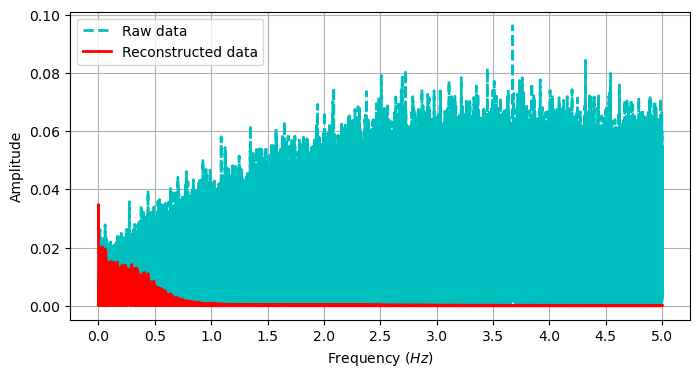

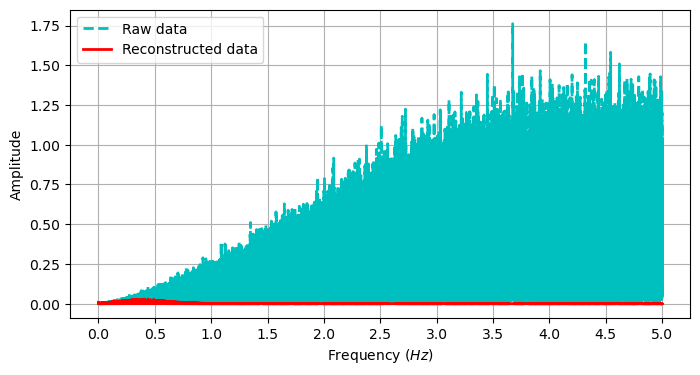

In [43]:
def displaySpectrum_smooth(data_raw, data_smooth):
    import copy; from scipy.fftpack import fft
    from scipy import fftpack, arange; import matplotlib.pyplot as plt
    from pylab import plot, show, title, xlabel, ylabel, subplot
    
    N = len(data_raw); duration = N*0.1; dt = 0.1 #duration and sampling step(s)
    fs = 1/dt; #sampling frequency
    data_raw[:len(data_raw)-1,-6] = (data_raw[1:,-7] - data_raw[:len(data_raw)-1,-7])/0.1 #acceleration explicit
    data_raw[1:,-5] = (data_raw[1:,-6] - data_raw[:len(data_raw)-1,-6])/0.1 #jerk implicit

    series_raw = copy.deepcopy(data_raw); series_smooth = copy.deepcopy(data_smooth); 
    hat_a_hz = fft(series_raw[:,-6],N); hat_j_hz = fft(series_raw[:,-5],N); #Fourier transform of raw data
    tilde2_j_hz = fft(series_smooth[:,-1],N); tilde2_a_hz = fft(series_smooth[:,-2],N); # Fourier transform of reconstructed data
    frq = np.linspace(0, fs, N)
    mag_hat_a = 2*(np.absolute(hat_a_hz))/N; mag_tilde_a2= 2*(np.absolute(tilde2_a_hz))/N; 
    mag_hat_j = 2*(np.absolute(hat_j_hz))/N; mag_tilde_j2= 2*(np.absolute(tilde2_j_hz))/N; 
    
    font2 = {'weight' : 'normal', 'size' : 10,}; font1 = 10 # text format

    plt.figure(figsize=(8,4)); plt.xticks(np.arange(0, 5.5, 0.5),fontsize=10); plt.yticks(fontsize=10) 
    plt.figure(1)
    plt.ylabel("Amplitude", font2); plt.xlabel("Frequency ($Hz$)", font2)
    plt.plot(frq[:len(frq) // 2],mag_hat_a[:len(frq) // 2], color = "c", linewidth=2, linestyle='--', label = "Raw data");
    plt.plot(frq[:len(frq) // 2],mag_tilde_a2[:len(frq) // 2], color = "r", linewidth=2, label = "Reconstructed data"); 
    plt.grid(); plt.legend(fontsize=10, loc = 2)

    plt.figure(figsize=(8,4)); plt.xticks(np.arange(0, 5.5, 0.5),fontsize=10); plt.yticks(fontsize=10); #plt.ylim(0,2); 
    plt.figure(2)
    plt.ylabel("Amplitude", font2); plt.xlabel("Frequency ($Hz$)", font2)
    plt.plot(frq[:len(frq) // 2],mag_hat_j[:len(frq) // 2], color = "c", linewidth=2, linestyle='--', label = "Raw data");
    plt.plot(frq[:len(frq) // 2],mag_tilde_j2[:len(frq) // 2], color = "r", linewidth=2, label = "Reconstructed data");  
    plt.grid(); plt.legend(fontsize=10, loc = 2)

displaySpectrum_smooth(raw1, smooth_traj1)

In [ ]:
#recalculate the positions
smooth_traj1[:,4] = smooth_traj1[:,4] + smooth_traj1[:, -4] - smooth_traj1[:,-8]

At each time instant, we also calculate the residuals between the raw and the reconstructed positions, which can be regarded as a reflection of the detection errors

In [45]:
processed_data = pd.DataFrame(smooth_traj1[:, [0,1,2,3,4,5,6,-4,-3,-2,-1]])
processed_data.columns = ["vehicle_id", "frame_id", "travel_time", "local_x", "local_y", "v_length", "front_vehicle", "travel_distance", "speed","acceleration","jerk"]
processed_data

,vehicle_id,frame_id,travel_time,local_x,local_y,v_length,front_vehicle,travel_distance,speed,acceleration,jerk
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,12.000,0.000,5.146,14.700,4.359,0.000,0.005,0.000,0.000,0.000
2,1.000,13.000,0.100,5.163,15.083,4.359,0.000,0.388,3.828,0.099,0.000
3,1.000,14.000,0.200,5.179,15.467,4.359,0.000,0.772,3.837,0.138,0.396
4,1.000,15.000,0.300,5.195,15.852,4.359,0.000,1.157,3.851,0.186,0.478
...,...,...,...,...,...,...,...,...,...,...,...
1045793,2911.000,8588.000,69.200,16.366,463.761,4.542,2910.000,361.705,9.550,0.030,0.040
1045794,2911.000,8589.000,69.300,16.374,464.716,4.542,2910.000,362.660,9.553,0.034,0.033
1045795,2911.000,8590.000,69.400,16.382,465.671,4.542,2910.000,363.616,9.556,0.036,0.021
1045796,2911.000,8591.000,69.500,16.390,466.627,4.542,2910.000,364.572,9.560,0.036,0.008


# Print out data

In [ ]:
from google.colab import files
processed_data.to_csv('processed_NGSIMI80.csv') 
files.download('processed_NGSIMI80.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>